In [1]:
#!/usr/bin/env python
# coding: utf-8
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import time
import numpy as np
import pyspark
from utilities import *
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [2]:
sc = pyspark.SparkContext()

In [3]:
inh = 'ATV'
vec_string = 'dist_vec'
#vec_string = 'count_vec'

In [4]:
sparkfilename = get_shortest_path_folder(inh,vec_string)+"meanpysparkdata.csv"

In [5]:
header = 'path_id,inh_type,vec_type,root_mutation,path_length,path_type,fraction_above_inh_threshold,path_variance,path_mean'.split(",")

In [6]:
c = {v:i for i,v in enumerate(header)}

In [7]:
#header = [header[c['path_id']],header[c['path_type']]]

In [8]:
id_mean_frac_spikes = sc.textFile(sparkfilename).map(lambda x:x.split(",")).filter(lambda x:x[c['path_type']]=='spikes').map(lambda x:[x[c['path_id']],float(x[c['path_mean']]),float(x[c['fraction_above_inh_threshold']])])
print(id_mean_frac_spikes.count())

3087415


In [9]:
id_mean_frac_from_image = id_mean_frac_spikes.filter(lambda x: x[1] > 50 and 0.3<x[2]<0.6)
print(id_mean_frac_from_image.count())

7888


In [10]:
id_mean_frac_from_image.take(1)

[['591141', 76.225, 0.3077]]

In [11]:
id_meanfrac = id_mean_frac_from_image.map(lambda x:(x[0],x[1:])).collectAsMap()

In [12]:
path_ids = id_mean_frac_from_image.map(lambda x:(int(x[0]),1)).collectAsMap()

In [13]:
len(path_ids), max(path_ids.keys()), min(path_ids.keys())

(7888, 3567086, 591141)

In [14]:
del id_mean_frac_spikes

In [15]:
id_path = {}
id_root = {}
id_len = {} 
count = -1
for i in range(10):
    spfile = get_shortest_paths_file(i,inh,vec_string)
    sp=open(spfile)
    next(sp)
    for path in sp:
        if 'mutation' not in path:
            count += 1
            if path_ids.get(count,-1) == 1:
                path = path.strip().split(",")
                root = path[0]
                id_path[str(count)] = path
                id_root[str(count)] = root 
                id_len[str(count)] = len(path)
    sp.close()

In [16]:
len(id_path)

7888

In [17]:
ids = sorted(id_path.keys())

In [30]:
#intersections = dict()
sims = np.zeros((len(id_path),len(id_path)))
edge_distance = dict()
sameroots = np.zeros((len(id_root),len(id_root)))
avgsim = 0 

In [31]:
for i in range(len(ids)):
    for j in range(i+1, len(ids)):
        id1, id2 = ids[i], ids[j]
        minlen = min(id_len[id1], id_len[id2])
        ins = set(id_path[id1]).intersection(id_path[id2])
        isns = len(ins)*100.0/minlen
        sims[i,j] = isns
        sims[j,i] = isns
        if id_root[id1] == id_root[id2]:
            sameroots[i,j] = 1
            sameroots[j,i] = 1 
        edge_distance[(id1, id2)] = isns
        avgsim += isns

In [32]:
avgsim/ len(edge_distance)

44.633350376837335

In [37]:
sim_for_sameroots = np.mean((sims[sameroots!=0]))
sim_fod_differentroots = np.mean((sims[sameroots==0]))
sim_for_sameroots, sim_fod_differentroots 

(86.01794682407107, 43.52892960274695)

In [38]:
# How many distinct roots are there?
root_ids = sc.parallelize([(r,i) for i,r in id_root.items()]).groupByKey().map(lambda x: (x[0], list(x[1])))
#filtered_root_ids = root_ids.filter(lambda x:len(x[1])>100).collectAsMap()
filtered_root_ids = root_ids.collectAsMap()

In [39]:
root_simcombs = root_ids.map(lambda x:(x[0],[(x[1][i], x[1][j]) for i in range(len(x[1])) for j in range(i+1, len(x[1]))])).filter(lambda x:x[1])
tmp = root_simcombs.flatMap(lambda x:[(x[0], y) for y in x[1]]).collect()

In [40]:
root_sim = sc.parallelize([(root,edge_distance[key]) for root, key in tmp]).groupByKey().map(lambda x:round(np.mean(list(x[1])),3)).collect()

Text(0, 0.5, 'Counts')

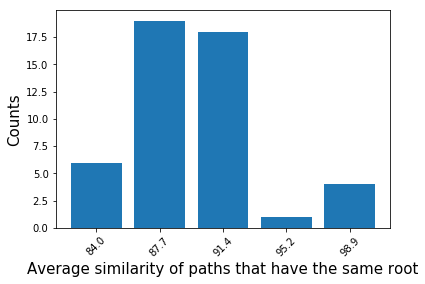

In [47]:
counts,bins = np.histogram(root_sim ,bins=5)
bins = [str(round(x,1)) for x in bins[1:]]
ypos = range(len(counts))
plt.bar(ypos,counts)
plt.xticks(ypos,bins,rotation=45)
plt.xlabel("Average similarity of paths that have the same root",fontsize=15)
plt.ylabel("Counts",fontsize=15)

# If I color each of these by a color, and plot the diagram, what does it look like? 
# If I plotted root vs avg sim, what would it look like? 

In [53]:
from itertools import cycle
possible_color_choices = ['red','green','blue','hotpink','dimgrey','steelblue','purple','teal','black','yellow','lime','orange','gold','dodgerblue','lightpink','cyan','orchid','peru','chocolate','olive','slateblue','lightgray','darkgoldenrod','greenyellow','palegreen','navajowhite','tan','mediumturquoise']
colors = cycle(possible_color_choices)
viz_frac, viz_y, viz_col = [],[],[] 
for root, points in filtered_root_ids.items():
    viz_col += [next(colors)]*len(points)
    for point in points:
        mean, frac =  id_meanfrac[point]
        viz_frac.append(frac)
        viz_y.append(mean)

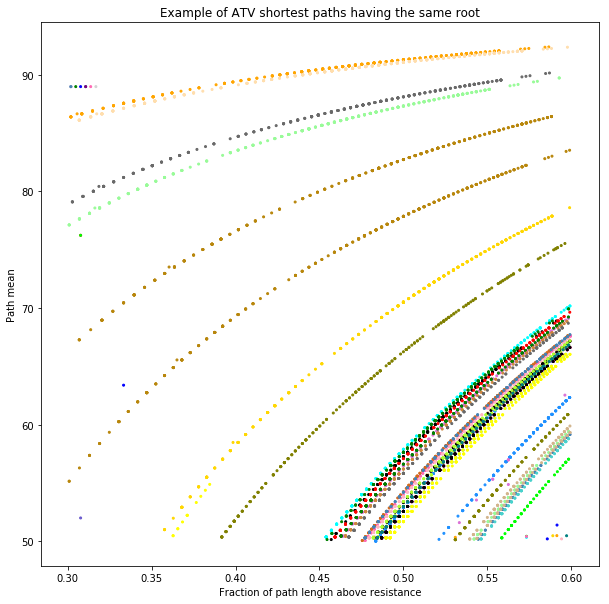

In [59]:
fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = 10, 10
ax.scatter(viz_frac,viz_y,s=4,color=viz_col)
plt.xlabel("Fraction of path length above resistance")
plt.ylabel("Path mean")
plt.title("Example of ATV shortest paths having the same root")
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=200, min_samples=2).fit(intersections)

In [ ]:
cluster_point = {i:[] for i in set(clustering.labels_)}

In [ ]:
for ind,c in enumerate(clustering.labels_):
    cluster_point[c].append(ids[ind])

In [ ]:
len(cluster_point[-1])

In [ ]:
len(cluster_point)

In [ ]:
len(ids)

In [ ]:
next(colors)

In [ ]:
id_mean_frac_from_image.count()